# 1. Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import graph

Let's start by loading the datasets and by saving them into three separate dataframes

In [2]:
# Answers to questions
df_a2q = pd.read_table("data/sx-stackoverflow-a2q.txt", 
                       delimiter=" ", 
                       names=["src", "tgt", "timestamp"],
                       nrows=10000)

# Comments to answers
df_c2a = pd.read_table("data/sx-stackoverflow-c2a.txt", 
                       delimiter=" ", 
                       names=["src", "tgt", "timestamp"],
                       nrows=10000)

# Comments to questions
df_c2q = pd.read_table("data/sx-stackoverflow-c2q.txt", 
                       delimiter=" ", 
                       names=["src", "tgt", "timestamp"],
                       nrows=10000)

Let's also convert the UNIX times in the `timestamp` column into `datetime` objects

In [3]:
df_a2q["timestamp"] = pd.to_datetime(df_a2q["timestamp"], unit='s')
df_c2a["timestamp"] = pd.to_datetime(df_c2a["timestamp"], unit='s')
df_c2q["timestamp"] = pd.to_datetime(df_c2q["timestamp"], unit='s')

Now we can save all three as separate graphs (ignoring rows with users commenting their own comments/answers)

In [4]:
G_a2q = graph.graph_from_df(df_a2q)   
G_c2a = graph.graph_from_df(df_c2a)
G_c2q = graph.graph_from_df(df_c2q)

in order to merge them into a single graph `G`, which will contain all nodes and edges in the three graphs, assigning to each edge a `timestamp` attribute (with the older date among the three graphs) and a `weight` attribute (i.e. the number of graphs that edge was in)

In [5]:
G = graph.merge_graphs(G_c2a, G_c2q)
G = graph.merge_graphs(G, G_a2q)

To check if our own implementation works, we can test it against `networkx`'s, and see if the two merged graphs have the same nodes and each of those has the same neighbors:

In [6]:
Gx_a2q = graph.graph_from_df(df_a2q, "networkx")   
Gx_c2a = graph.graph_from_df(df_c2a, "networkx")
Gx_c2q = graph.graph_from_df(df_c2q, "networkx")

Gx = nx.compose(Gx_c2a, Gx_c2q)
Gx = nx.compose(Gx, Gx_a2q)

graph.test_graph(G, Gx)

OK! Same nodes and neighbors


By merging the three graphs, we obtain

In [7]:
G.summary()

Directed graph with 6763 nodes and 22449 edges


where each edge has by default a direction (unlike `Gx` which is undirected), which will be that of the older interaction between the two users (i.e. the first occurrence in the dataframe, whose entries are in chronological order from oldest to newest).

For instance, let's take a look at a random subgraph of G:

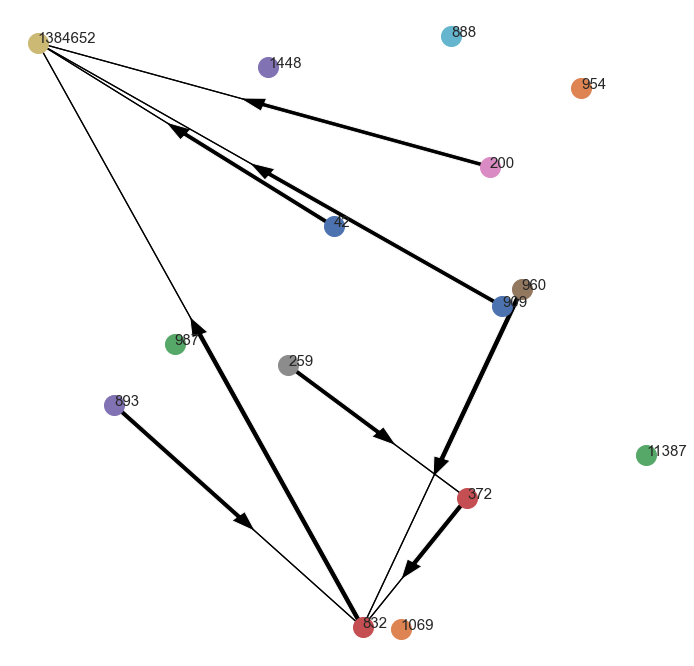

In [213]:
plt = graph.plot_subgraph(G)
plt.show()

# 2/3. Functionalities & Visualization

In [9]:
from func import func_selector
import visual

### Functionality 1 - Overall features of the graph

Let's take a look at the overall features of one of the graphs we built and the distribution of the degrees of each of its nodes.

,Graph features
Directed,True
Users,1501
Answers/comments,9248
Avg links per user,6.16
Dense (|E| ~ |V|^2),True


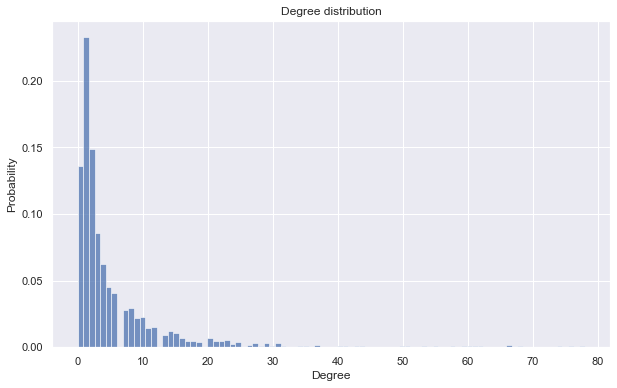

In [31]:
table, density = func_selector(G_a2q, 1)

plt.figure(figsize = (10,6))
visual.overall_features(G_a2q, table, density)
plt.show()

The vast majority of nodes have a degree close to zero, but there also many outliers which have a much higher degree than the rest, as we can appreciate in the box plot below.

This suggests that most interactions are created by a small percentage of very active users. 

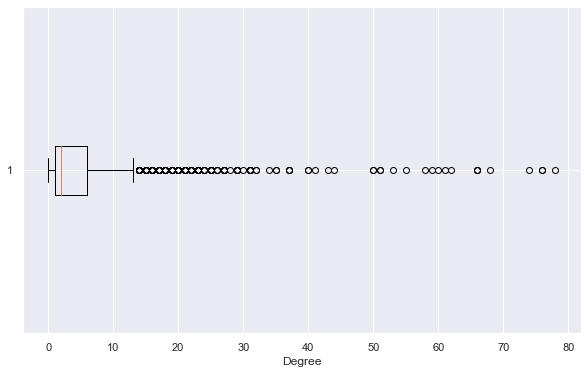

In [32]:
plt.figure(figsize = (10,6))
plt.boxplot(density, vert=False)
plt.xlabel("Degree")
plt.show()

### Functionality 2 - Find the Best users!

We are now interested in computing several metrics to assess the "importance" – the centrality – of a node within the graph in a well defined time interval.

Due to the prohibitively long execution times (especially of the betweenness centrality), we could only test the following functionalities and compare their results for short windows of time.

#### Betweenness

The betweenness centrality measures how "central" a node is by finding in how many paths between all possible node pairs it appears in; in a sense, it represents how many "communications" between nodes it affects.

Given a node $v$ in a directed and weighted graph $(V,E)$, its betweenness centrality (normalized between 0 and 1) is defined as

$$
BC(v) = \frac{1}{(N-1)(N-2)}\sum_{s\neq v\neq t\ \in\ V} \frac{\sigma_{st}(v)}{\sigma_{st}}
$$

where $\sigma_{st}$ is the number of equivalent (in weight) shortest paths between a node $s$ and a node $t$, $\sigma_{st}(v)$ is the number of those which also contain $v$ in the middle, and $N$ is the total number of nodes in the graph.

**Remark:** in the case of an undirected graph it has to be multiplied by 2

Sources
- https://kops.uni-konstanz.de/bitstream/handle/123456789/5739/algorithm.pdf
- http://aris.me/contents/teaching/data-mining-ds-2021/resources/graphs.pdf

For node $238$ in the time window `2008-08-01 / 2008-08-10` we obtained:

In [286]:
func_selector(G, 2)

Node:  238
Time start [yyyy-mm-dd]:  2008-08-01
Time end [yyyy-mm-dd]:  2008-08-10
Metric [btw | pagerank | cc | dc]:  btw


0.5616119645843778

which is quite a high value. This means that this particular user was present in many of the interactions among other users, for instance commenting/answering posts which were also commented/answered by many other users.

#### PageRank

PageRank is an algorithm notably used by Google to rank web pages in search results and measure their importance.

Within our context, it can be used to assign to each node a certain asymptotic probability of being reached in a large number of steps; this means that the higher this probability is, the more the node is connected to the rest and in that sense "central" in the graph.

We can compute it by interpreting our graph as a Markov Chain and the corresponding adjacency matrix as a stochastic matrix filled with the transitional probabilities between all pairs of nodes. We will assume uniform probability to go from a given node to any of its neighbors (in the case of a directed graphs only its "targets"). The stationary distribution of all nodes will be the left eigenvector of that matrix corresponding to the principal eigenvalue, with components the limit probability – the rank – of each node.

Sources
- https://en.wikipedia.org/wiki/PageRank
- *Trattatello di Probabilità (L. Leuzzi, E. Marinari, G. Parisi)*

For node $238$ in the time window `2008-08-01 / 2008-08-10` we obtained:

In [219]:
func_selector(G, 2)

Node 238
Time start [yyyy-mm-dd] 2008-08-01
Time end [yyyy-mm-dd] 2008-08-10
Metric [btw | pagerank | cc | dc] pagerank


0.003447465483984921

which is a very low figure. Given the graph is directed, this suggests that even though this user commented/answered many posts by other users – as we can hypothesize from its betweenness centrality – very few users in comparison commented his own posts, i.e. it's a node with many outgoing connections but not as many incoming, hence not very reachable.

#### Closeness Centrality

Closeness centrality measures how close a given node is to the rest of nodes in the graph.

For a node $v$, it is a defined as

$$CC(v) = \frac{N-1}{\sum_{u\in V} d(u,v)}$$

where $d(u,v)$ is the distance in terms of number of edges of the shortest path between $v$ and another node $u$, and $N-1$ is again needed to normalize the measure.

Sources
- https://kops.uni-konstanz.de/bitstream/handle/123456789/5739/algorithm.pdf
- http://aris.me/contents/teaching/data-mining-ds-2021/resources/graphs.pdf

For node $238$ in the time window `2008-08-01 / 2008-08-10` we obtained:

In [11]:
func_selector(G, 2)

Node238
Time start [yyyy-mm-dd]2008-08-01
Time end [yyyy-mm-dd]2008-08-10
Metric [btw | pagerank | cc | dc]cc


0.322400558269365

This value reinforces what we saw earlier with the betweenness centrality: this node is "central" in the sense that it communicates well with others (its distance to the other nodes is "small").

#### Degree Centrality

The degree centrality is the simplest notion of centrality and it's defined as the (normalized) number of neighboring nodes of a given node $v$:

$$DC(v)=\frac{\text{deg}(v)}{N-1}$$

In [69]:
func_selector(G, 2)

Node 238
Time start [yyyy-mm-dd] 2008-08-01
Time end [yyyy-mm-dd] 2008-08-10
Metric [btw | pagerank | cc | dc] dc


0.012987012987012988

Let's see 10 random neighbours of the chosen node: $238$

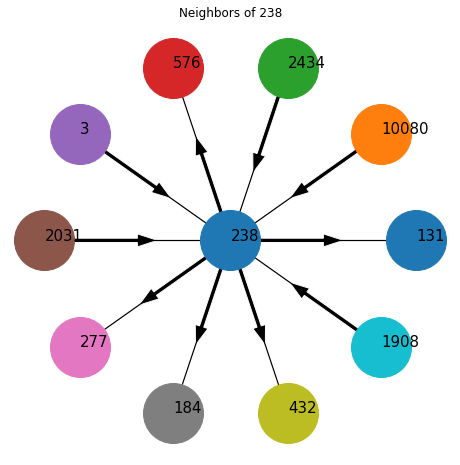

In [14]:
plt = graph.plot_neighbors(G, "238", max_neighbors=10)
plt.show()

Now let's plot the evolution of the metric (we choose to use **Degree Centrality**) over the interval of time chose splitted.

We start of course by splitting the time interval into chunks of 1 month each.

In [158]:
time_start = pd.to_datetime(input("Time start [yyyy-mm-dd]"), format='%Y-%m-%d')
time_end = pd.to_datetime(input("Time end [yyyy-mm-dd]"), format='%Y-%m-%d')
time_interval = (time_start, time_end)

Time start [yyyy-mm-dd]2008-08-01
Time end [yyyy-mm-dd]2008-12-01


In [188]:
inters = list(pd.date_range(time_start, time_end, freq = "M"))

if time_start != inters[0]:
    inters.insert(0, time_start)
if time_end != inters[-1]:
    inters.append(time_end)
inters[0] -= pd.Timedelta('1d')
inters = zip(map(lambda d: d + pd.Timedelta('1d'), inters[:-1]), inters[1:])
intervals = list(map(lambda t: t[0].strftime('%Y-%m-%d') + ' - ' + t[1].strftime('%Y-%m-%d'), inters))

In [189]:
for i in range(len(intervals)):
    intervals[i] = intervals[i].split(' - ')

In [191]:
lista = []
for i in intervals:
    lista.append(i[0])
    lista.append(i[1])

In [193]:
lista

['2008-08-01',
 '2008-08-31',
 '2008-09-01',
 '2008-09-30',
 '2008-10-01',
 '2008-10-31',
 '2008-11-01',
 '2008-11-30',
 '2008-12-01',
 '2008-12-01']

In [195]:
deg = []
for i in range(0,len(lista)-2, 2):
    Gm = graph.filter_graph_by_time(G, [pd.to_datetime(lista[i], format='%Y-%m-%d'), pd.to_datetime(lista[i+2], format='%Y-%m-%d')])
    if(bool(Gm.nodes)):
        deg.append(Gm.degree('372') / (len(Gm) - 1))

2008-08-01 2008-09-01
2008-09-01 2008-10-01
2008-10-01 2008-11-01
2008-11-01 2008-12-01


In [215]:
intervalli = []
for i in range(0, len(lista)-2, 2):
    intervalli.append(lista[i])

Text(0, 0.5, 'degree centrality')

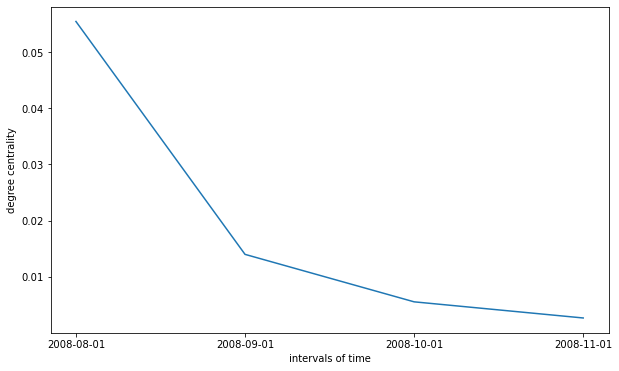

In [221]:
plt.figure(figsize = (10,6))
plt.plot(intervalli, deg)
plt.xlabel("intervals of time")
plt.ylabel("degree centrality")

### Functionality 3 - Shortes Ordered Route

In [54]:
p = shortest_path(G, '1', '8')

In [55]:
print(p)

['1', '380', '905', '8']


In [15]:
a = input()

404


In [16]:
G.nodes[a]

{'1385358': {'time': Timestamp('2008-09-10 21:16:50'), 'weight': 1},
 '193': {'time': Timestamp('2008-08-05 21:36:12'), 'weight': 1},
 '357': {'time': Timestamp('2008-08-06 02:32:03'), 'weight': 1},
 '396': {'time': Timestamp('2008-08-07 11:50:54'), 'weight': 1},
 '277': {'time': Timestamp('2008-08-06 11:14:42'), 'weight': 1},
 '202': {'time': Timestamp('2008-08-07 12:54:00'), 'weight': 1},
 '288': {'time': Timestamp('2008-08-07 23:55:01'), 'weight': 1},
 '326': {'time': Timestamp('2008-08-08 02:22:36'), 'weight': 1},
 '756': {'time': Timestamp('2008-08-09 00:41:18'), 'weight': 1},
 '27687': {'time': Timestamp('2008-08-09 12:52:00'), 'weight': 1},
 '733': {'time': Timestamp('2008-08-12 21:43:31'), 'weight': 1},
 '233': {'time': Timestamp('2008-08-13 10:31:16'), 'weight': 1},
 '105': {'time': Timestamp('2008-08-15 11:27:58'), 'weight': 1},
 '1573': {'time': Timestamp('2008-08-17 03:13:46'), 'weight': 1},
 '271': {'time': Timestamp('2008-08-19 01:49:05'), 'weight': 1},
 '1368': {'time': 

In [214]:
import func
reload(func)
from func import func_selector
func_selector(G, 3)

Start Node:  1
End Node:  8
Nodes to be visited (comma-separated) 380,905
Time start [yyyy-mm-dd]:  2008-08-01
Time end [yyyy-mm-dd]:  2016-12-10


['1', '380', '905', '8']


In [186]:
shortest_path(G, "1", "50")

(2, ['1', '430', '50'])

In [56]:
a = shortest_path(G, "1", "8")
print(a)

['1', '380', '905', '8']


In [ ]:
func_selector(G, 2)

In [246]:
import func
reload(func)
from func import num_of_shortest_paths

num_of_shortest_paths(G, "1", "404")

(6, 2)

In [ ]:
# import visual
# ##call function draw_short_ord_route
# 
# # 404 -> 396/202 -> 122 -> 5 -> 32 -> 267
# #choose 404 , 267, 122,32 
# #time 2008-08-01
# #end 2008-09-30
# res = func_selector(G, 3)
# 
# Start Node: 404
# End Node: 267
# Nodes to be visited (comma-separated)122,32
# Time start [yyyy-mm-dd]: 2008-08-01
# Time end [yyyy-mm-dd]: 2008-09-30
# ['404', '396', '122', '5', '32', '267']
# 
# print(res)
# visual.draw_short_ord_route(res)



# 4. Algorithmic question

A number n of kids are in a camp. Between some k pairs of them (a kid can be part of more than one pairs) there are often fights. At night there are two dormitories where the kids can sleep. We want, if possible, to assign each kid in one of the two dormitories in such a way that each pair of kids that fights often is assigned to a different dormitory. (There are no space problems and the two dormitories can have different number of kids.)

In [13]:
n = [1,3,4,56,7,32,2]
n.sort()
n

[1, 2, 3, 4, 7, 32, 56]

In [17]:
def tuple_order(k):
    out = []
    for pair in k:
        if(pair[0] > pair[1]):
            pair = list(pair)
            temp = pair[0]
            pair[0] = pair[1]
            pair[1] = temp
            pair = tuple(pair)
        out.append(pair)
    return out

In [18]:
# n -> list of kids
# k -> list of pairs of kids fighting
def dorm_algo(n, k):
    # kids in 1st and 2nd dorm
    dorm0 = []
    dorm1 = []
    # Creating a list for kids who don't get in argues
    safe = []
    
    # First of all I order the list of kids...
    n.sort()
    # ...and the elements of the pairs using the aux function
    k = tuple_order(k)
    # Then I start checking
    for pair in k:
        if(pair[0] not in safe): # if kid0 not in safe list...
            safe.append(pair[0]) # ...I add him...
            dorm0.append(pair[0]) # ...and put him in dorm0
        
        if(pair[1] not in safe): # if kid1 not in safe list...
            safe.append(pair[1]) # ...I add him...
            dorm1.append(pair[1]) # ...and put him in dorm1
            
    # Now I check if kids from the same pairs are in the same dorm
    # If so, I block the algorithm
    for pair in k:
        if(((pair[0] in dorm0) and (pair[1] in dorm0)) or (pair[0] in dorm1) and (pair[1] in dorm1)):
            print("Nothing can be done!")
            return 
    
    # Now is time to add the other kids in the dorms
    for kid in n:
        if((kid not in dorm0) and (kid not in dorm1)):
            dorm0.append(kid)
            
    # Print the final dorms with the kids
    print("Fighting solved! Here the dorms:")
    print("First dormitory:", dorm0)
    print("Second dormitory:",dorm1)

Let's use as list of kids this:

In [19]:
n = [1,2,3,4,5,6]

In [20]:
k = [(3,2), (4,2)]
dorm_algo(n, k)

Fighting solved! Here the dorms:
First dormitory: [2, 1, 5, 6]
Second dormitory: [3, 4]


In [21]:
k = [(1,3),(4,1),(3,4)] 
dorm_algo(n, k)

Nothing can be done!


In [22]:
k = [(5,4), (6,5), (2,6)]
dorm_algo(n, k)

Nothing can be done!


In [23]:
k = [(5,4), (6,5)]
dorm_algo(n, k)

Nothing can be done!


In [24]:
k = [(1,3),(4,1),(3,2),(2,5),(1,2)]
dorm_algo(n,k)

Nothing can be done!


In [25]:
k = [(1,3),(4,1),(3,2),(2,5),(2,6)]
dorm_algo(n,k)

Fighting solved! Here the dorms:
First dormitory: [1, 2]
Second dormitory: [3, 4, 5, 6]
